# Convolve a simulated image wit the XMM PSF

In [3]:
import os

from astropy.io import fits
from astropy.convolution import convolve, convolve_fft

from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u

import numpy as np

import matplotlib.pylab as plt
%matplotlib inline

import aplpy

from photutils import SkyCircularAperture, SkyCircularAnnulus, aperture_photometry

In [12]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 1. Read the FITS files of the image and the PSF

First we read the simulated cluster image `pn_500_7000_simulated.fits`, produced using the double-$\beta$ model (Jukka's parameters). The image is generated in another notebook `simulate_xmm_cluster.ipynb`.

Then we read the PSF image produced with `XMM-SAS` function
```
psfgen image=pn_500_7000_simulated.fits withimage=yes \
    level=ELLBETA energy=1500 x=207.220833 y=26.590278 \
    coordtype=EQPOS xsize=199 ysize=199 output=pn_psf.fits
```
This should be the most accurate represetation of the actual PSF.

In [4]:
home = os.path.expanduser('~')
wdir =  f'{home}/Desktop/Jukka/a1795'
hdu1 = fits.open(f'{wdir}/pn_500_7000_simulated.fits.gz')
psf = fits.open(f'{wdir}/pn_psf.fits.gz')

## 2. Define the sky apertures
The files were read and the next step is to set up the apertures. Centred on the cluster centre.

In [5]:
wcs = WCS(hdu1[0].header)
arcmin2pix = wcs.pixel_scale_matrix[1,1]*60.0
center = SkyCoord(207.2208333,26.59027778,unit=(u.deg,u.deg),frame='icrs')
aperture2 = SkyCircularAperture(center, r=2. * u.arcmin)
aperture4 = SkyCircularAperture(center, r=4. * u.arcmin)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


## 3. Define the sky mask

Next we define a sky pixel mask, so all pixels outside `rmask` will be set to zero.

In [6]:
# grid to mask the outside area
rmask = 1.0 # arcmin, the cool core scale
nx,ny = hdu1[0].data.shape
y, x = np.mgrid[0:ny, 0:nx]
xy = wcs.wcs_world2pix(center.ra.value,center.dec.value,1)
y = y - xy[1]
x = x - xy[0]
rx = np.sqrt(x*x + y*y)
rmax = rmask/arcmin2pix
ix = np.where(rx >= rmax)
image_mask = hdu1[0].data.copy()
image_mask[ix] = 0.0

## 4. Perform the aperture photometry

And we intergate the flux within the previously defined apertures using `photutils` package. 

In [8]:
photo2 = aperture_photometry(hdu1[0].data, aperture2,wcs=wcs)
photo4 = aperture_photometry(hdu1[0].data, aperture4,wcs=wcs)
ap_flux2 = photo2['aperture_sum'][0]
ap_flux4 = photo4['aperture_sum'][0]
annulus = ap_flux4 - ap_flux2

Print some numbers as a result of the calculations:

In [10]:
print ("Total counts in aperture4: {}".format(ap_flux4))
print ("Total counts in aperture2: {}".format(ap_flux2))
print ("Total counts in annulus: {}".format(annulus))
ratio = ap_flux2/annulus
print ("Ratio center to annulus: {}".format(ratio))

Total counts in aperture4: 1270090.768441915
Total counts in aperture2: 848094.5693142086
Total counts in annulus: 421996.19912770647
Ratio center to annulus: 2.0097208720535282


So, within the central 2 arcmin aperture we have twice as many counts as in the annulus from 2 to 4 arcmin. This can probably be derived analytically with the double-$\beta$ model.

## 5. Convolve the masked image with the PSF

I use the FFT convolution. If the masked image or the PSF contain `NaN` then this probably will not work. Luckyly this is not the case for the the simulated image and the generated PSF, so we can do this as it is much faster than the brute-force convolution.

In [13]:
result = convolve_fft(image_mask,psf[0].data)

## 6. Check the convolution

We check the result visually, using `APLpy`.

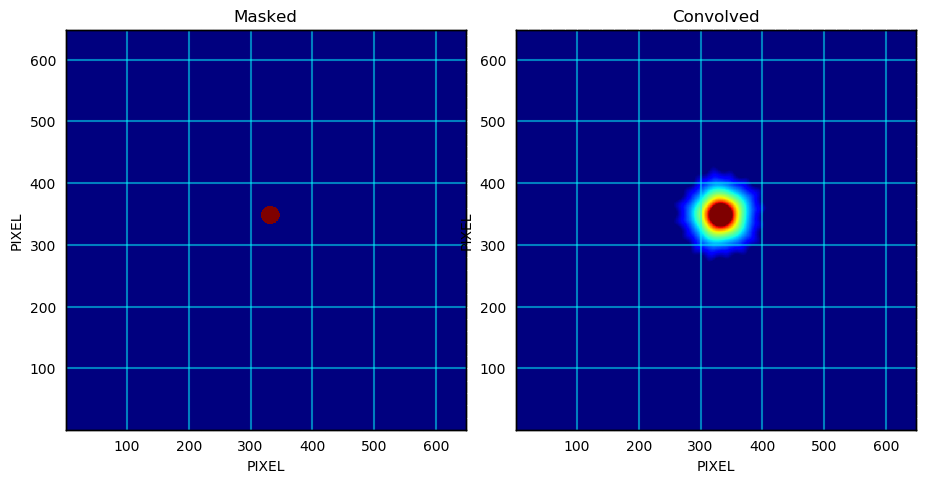

In [14]:
fig = plt.figure(figsize=(10,10),dpi=100)
f0 = aplpy.FITSFigure(image_mask, figure=fig, subplot=[0.1,0.1,0.4,0.4])
f0.show_colorscale(vmin=1,vmax=100,stretch='log')
f0.set_title('Masked')
f0.add_grid()
f0.grid.set_color('cyan')
f0.grid.set_alpha(0.5)
f1 = aplpy.FITSFigure(result, figure=fig, subplot=[0.55,0.1,0.4,0.4])
f1.show_colorscale(vmin=1,vmax=100,stretch='log')
f1.set_title('Convolved')
f1.add_grid()
f1.grid.set_color('cyan')
f1.grid.set_alpha(0.5)
#f0.show_circles(aperture1.positions.ra.value,aperture1.positions.dec.value,\
#                    aperture1.r.value/60.0,edgecolor='black')
#f0.show_circles(aperture2.positions.ra.value,aperture2.positions.dec.value,\
#                    aperture2.r.value/60.0,edgecolor='blue')
#f0.recenter(aperture.positions.ra.value,aperture.positions.dec.value,radius=8.0/60.0)
#f0.show_markers(aperture.positions.ra.value,aperture.positions.dec.value)
#f0.tick_labels.set_xformat('hh:mm:ss.s')
#f0.tick_labels.set_yformat('dd:mm:ss')
#f0.hide_ytick_labels()
#f0.hide_xtick_labels()
#

## 7. Calculate the aperture photometry with the convolved image

Similar to step 4, we use the same apertures and centre and calculate the flux in an aperture of 2 arcmin and in an annulus between 2 and 4 arcmin.


In [15]:
#
# after convolution
#
photo2x = aperture_photometry(result, aperture2,wcs=wcs)
photo4x = aperture_photometry(result, aperture4,wcs=wcs)
ap_flux2x = photo2x['aperture_sum'][0]
ap_flux4x = photo4x['aperture_sum'][0]
annulsx = ap_flux4x - ap_flux2x

## 8. Check the results


In [16]:
print ("Total counts in aperture4: {}".format(ap_flux4x))
print ("Total counts in aperture2: {}".format(ap_flux2x))
print ("Total counts in annulus: {}".format(annulsx))
print ("Ratio of annulus to center counts: {}".format(annulsx/ap_flux2x))

Total counts in aperture4: 450354.33820036525
Total counts in aperture2: 407870.50309725024
Total counts in annulus: 42483.83510311501
Ratio of annulus to center counts: 0.10416010665273683


The annulus after convolution with the PSF contains 10% of the flux in the central 2 arcmin region.

Let's check with the non-masked annulus:

In [18]:
print ("Ratio to masked to non-masked counts in the annulius: {}".format(annulsx/annulus))

Ratio to masked to non-masked counts in the annulius: 0.10067350177781662
